# Lab 10: AutoML

In [48]:
import logging
import openml as oml
from sklearn.model_selection import train_test_split
%matplotlib inline

## Exercise: Using GAMA

### Installation

In this exercise we will use AutoML tool [GAMA](https://github.com/PGijsbers/gama/).
The exercise is self-contained, but if you want to know more the documentation is found [here](https://pgijsbers.github.io/gama/develop/).
First, make sure GAMA is installed and/or check the right version is installed:

In [ ]:
!pip install --quiet gama

In [81]:
from packaging import version
import gama
if version.parse(gama.__version__) < version.parse("20.1.0"):
    print("GAMA is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


*note*:
> GAMA is under active development. Parts of the interface are still subject to change. We are also using small time budgets because the lab only lasts two hours. For that reason some of the results may be affected more than usual by the randomness inherent to evolutionary search.

### Standard use case on NO<sub>2</sub> data

In lab session 1, we tested several models the predict **NO<sub>2</sub>** levels.
Here we will use GAMA automatically find a pipeline for this task.
First we have to fetch the data from OpenML, and split it into a train and test set:

In [7]:
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute, dataset_format='DataFrame');
X = X.drop('day',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

[WARNING] [14:38:00:openml.datasets.dataset] Cannot convert non-sparse data (<class 'pandas.core.frame.DataFrame'>) to 'DataFrame'. Returning input data.
[WARNING] [14:38:00:openml.datasets.dataset] Cannot convert non-sparse data (<class 'pandas.core.series.Series'>) to 'DataFrame'. Returning input data.


We can then import and use GAMA just like a scikit-learn classifier or regressor:

In [16]:
from gama import GamaClassifier, GamaRegressor
automl = GamaRegressor(
    max_total_time=60, # in seconds
    n_jobs=1,  # one subprocess
    scoring='r2',  # metric to optimize for
    verbosity=logging.INFO,  # to get printed updates about search progress
    keep_analysis_log="no2.log",  # name for a log file to record search output in
)

Using GAMA version 20.1.0.
GamaRegressor(post_processing_method=BestFitPostProcessing(),search_method=AsyncEA(),keep_analysis_log=D:\repositories\engineer-private\labs\no2.log,verbosity=20,n_jobs=1,max_eval_time=None,max_total_time=60,random_state=None,max_pipeline_length=None,regularize_length=True,scoring=r2)


Starting AutoML is now as simple as calling `fit` with the training data. You can use the `score` function to get the model's score on the test set. Using GAMA, fit a model to the data and report the score.

In [17]:
# solution:
automl.fit(X_train, y_train)
automl.score(X_test, y_test)

preprocessing took 0.0020s.
Starting EA with new population.
Search phase evaluated 112 individuals.
search took 53.0341s.
postprocess took 0.1501s.


0.5160622839447353

How does the score compare to the maximum of `0.4796` found in lab 1?
It's likely better. Because the dataset is so small, even in one minute time GAMA can evaluate many pipelines.
GAMA also considers more (and different) models than those from lab 1.

The number of pipelines that have been evaluated should've been printed as cell output.
But we can also have a closer look at which pipelines have been evaluated.
We do this by parsing the log GAMA created (filename set by `keep_analysis_log`) with the builtin `GamaReport` parser:

In [30]:
def transform_evaluations(df):
    """ The GamaReport was initially developed for use within GAMA tooling.
    For this reason it contains some hard to interpret, useless or internal data.
    For clarity, we filter this out for you.
    """
    df = df.drop(['id', 'length_cummax', 'relative_end'], axis=1)
    df['length'] = -df['length']
    return df

In [32]:
from gama.logging.GamaReport import GamaReport
report = GamaReport(logfile="no2.log")
evaluations = transform_evaluations(report.evaluations)
evaluations.sample(5).sort_values(by='n')  # Show 5 random samples from the dataframe, but sort them by order of n.

,n,start,duration,r2,length,pipeline,r2_cummax
8,8,2020-03-31 14:50:23.071341,00:00:00.014014,-inf,3.0,"LinearSVR(MaxAbsScaler(PCA(data, PCA.iterated_...",0.526649
56,56,2020-03-31 14:50:46.267466,00:00:00.106107,-0.738962,1.0,"LinearSVR(data, LinearSVR.C=25.0, LinearSVR.du...",0.547518
73,73,2020-03-31 14:50:53.928057,00:00:00.303274,0.391061,2.0,"ElasticNetCV(SelectPercentile(data, SelectPerc...",0.547518
74,74,2020-03-31 14:50:54.238343,00:00:00.709620,-0.008657,2.0,"ElasticNetCV(RBFSampler(data, RBFSampler.gamma...",0.547518
79,79,2020-03-31 14:50:56.255362,00:00:00.071072,-0.014366,2.0,"KNeighborsRegressor(RBFSampler(data, RBFSample...",0.547518


This dataframe has the following columns:
 - n: the n-th pipeline to be evaluated in search
 - start: start time of the evaluation
 - duration: the time it took to evaluate the model (in seconds)
 - r2: the r2 score of the pipeline (based on 5-fold cross-validation on the training data)
 - length: the number of steps in the pipeline times (i.e., length 2 means one preprocessing step and one estimator).
 - pipeline: the pipeline (more info below)
 - r2_cummax: the maximum r2 score found at evaluation `n`

Find the best pipeline of each length from the `evaluations` dataframe (or one of the best, in case of a tie).

In [41]:
# solution:
evaluations.sort_values('r2', ascending=False).drop_duplicates(['length'])

,n,start,duration,r2,length,pipeline,r2_cummax
87,87,2020-03-31 14:50:59.841370,00:00:00.736680,0.549169,1.0,"AdaBoostRegressor(data, AdaBoostRegressor.lear...",0.549169
96,96,2020-03-31 14:51:04.029687,00:00:00.604176,0.538464,3.0,"ElasticNetCV(RBFSampler(MinMaxScaler(data), RB...",0.549169
36,36,2020-03-31 14:50:34.156873,00:00:00.741385,0.531917,2.0,"AdaBoostRegressor(MinMaxScaler(data), AdaBoost...",0.547518
70,70,2020-03-31 14:50:48.543213,00:00:01.302885,0.463004,4.0,AdaBoostRegressor(PCA(PolynomialFeatures(PCA(d...,0.547518


To visualize the progress of search, plot:
 - The `r2` score for each evaluation as a function of `n`, preferably only for those evaluations with an `r2` score of at least 0.
 - The maximum `r2` score as a function of `n`

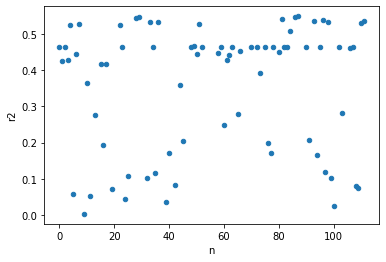

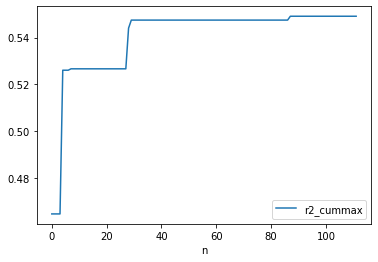

In [95]:
evaluations[evaluations['r2'] > 0].plot.scatter(x='n', y='r2')
evaluations.plot.line(x='n', y='r2_cummax')

### Automatic Ensembles on Covertype

Next we will take a look at a classification problem, and change the AutoML pipeline.
First, download the covertype dataset (id: 180) that we saw in lab 3.
First take a stratified subsample of 50% of the data (using `train_test_split`).
Then split that data into a train and test set (50%/50%). 
The train and test sets are now both 25% of the total data.

In [90]:
# Solution:
trees = oml.datasets.get_dataset(180)
X, y, _, _ = trees.get_data(target=trees.default_target_attribute, dataset_format='DataFrame')
X_sub, _, y_sub, _ = train_test_split(X, y, stratify=y, train_size=0.5)
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, stratify=y_sub, train_size=0.5)

[WARNING] [16:46:08:openml.datasets.dataset] Cannot convert non-sparse data (<class 'pandas.core.frame.DataFrame'>) to 'DataFrame'. Returning input data.
[WARNING] [16:46:08:openml.datasets.dataset] Cannot convert non-sparse data (<class 'pandas.core.series.Series'>) to 'DataFrame'. Returning input data.


Initialize a GamaClassifier, similarly to how the GamaRegressor was initialized, but:
 - specify the maximum runtime to at least 3 minutes,
 - set `n_jobs` to 2,
 - set the metric to accuracy,
 - specify a different log name,

Then start search (`fit`) and evaluate the model on the test data (`score`).
Take a short break once it's all running, or ask us a question about the lecture! :)

In [70]:
automl = GamaClassifier(
    max_total_time=180, # in seconds
    n_jobs=2,  # one subprocess
    scoring='accuracy',  # metric to optimize for
    verbosity=logging.INFO,  # to get printed updates about search progress
    keep_analysis_log="trees.log",  # name for a log file to record search output in
)

Using GAMA version 20.1.0.
GamaClassifier(post_processing_method=BestFitPostProcessing(),search_method=AsyncEA(),keep_analysis_log=D:\repositories\engineer-private\labs\trees.log,verbosity=20,n_jobs=2,max_eval_time=None,max_total_time=180,random_state=None,max_pipeline_length=None,regularize_length=True,scoring=accuracy)


In [71]:
automl.fit(X_train, y_train)

preprocessing took 0.2502s.
Starting EA with new population.
Search phase evaluated 35 individuals.
search took 161.0288s.
postprocess took 0.6211s.


In [72]:
automl.score(X_test, y_test)

0.781143561127618

How did the model perform? In lab 3 we had about 80% accuracy after tuning the number of trees in the RandomForest. How does this model compare?

The covertype dataset is quite large, and three minutes is not much time. For this reason we downsampled such that our training set contained only 25% of the original data. In our experience with these constraints, we find that GAMA can produce models with 80% accuracy, but it's also possible to see worse results. With more time we could search longer and evaluate more models on more of the data.

Up to this point GAMA has been using the best found pipeline to make predictions on the test data.
However, we saw that constructing ensembles of models can be a useful tool to gain additional performance.
GAMA can be configured to automatically build an ensemble from the models it found during search. To do this you should initialize GAMA with the `post_processing_method` specified:

In [134]:
from gama.postprocessing import EnsemblePostProcessing

automl_with_ensemble = GamaClassifier(
    max_total_time=180,
    n_jobs=2,
    verbosity=logging.INFO,
    keep_analysis_log="covtype_ensemble.log",
    scoring='accuracy',
    post_processing_method=EnsemblePostProcessing(),  # Specify to build an ensemble after search
)

Using GAMA version 20.1.0.
GamaClassifier(post_processing_method=EnsemblePostProcessing(ensemble_size=25,hillclimb_size=10000,max_models=200),search_method=AsyncEA(),keep_analysis_log=D:\repositories\engineer-private\labs\covtype_ensemble.log,verbosity=20,n_jobs=2,max_eval_time=None,max_total_time=180,random_state=None,max_pipeline_length=None,regularize_length=True,scoring=accuracy)


Again, start search and record the test set score:

In [135]:
# solution:
automl_with_ensemble.fit(X_train, y_train)
score = automl_with_ensemble.score(X_test, y_test)
print("ensemble score: {:.4f}".format(score))

preprocessing took 0.3584s.
Starting EA with new population.
Search phase evaluated 35 individuals.
search took 125.0366s.
Not downsampling because only 10000 samples were stored.
Ensemble size 11 , best score: 0.7573
Ensemble size 12 , best score: 0.771
Ensemble size 13 , best score: 0.7707
Ensemble size 14 , best score: 0.7724
Ensemble size 15 , best score: 0.7783
Ensemble size 16 , best score: 0.7803
Ensemble size 17 , best score: 0.7826
Ensemble size 18 , best score: 0.7828
Ensemble size 19 , best score: 0.7833
Ensemble size 20 , best score: 0.7835
Ensemble size 21 , best score: 0.7836
Ensemble size 22 , best score: 0.7833
Ensemble size 23 , best score: 0.7837
Ensemble size 24 , best score: 0.7836
Ensemble size 25 , best score: 0.7837
Building ensemble took 1.4192991256713867s. Fitting ensemble with timeout 53.18575620651245s.
postprocess took 1.4203s.
ensemble score: 0.7786


Note that this run was independent from the previous run. This means it might have found better or worse pipelines than last search. We cannot compare the performance of this ensemble directly to the previous best score. Run the code cell below to see how the single best pipeline would have scored *this* run:

In [136]:
# Currently post-hoc switching of post-processing method is not supported directly.
# We work around this:
from sklearn.metrics import log_loss

best, = automl_with_ensemble._evaluation_library.n_best(1)
best_pipeline = best.individual.pipeline
best_pipeline.fit(X_train, y_train)
test_score = best_pipeline.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(best.score[0], test_score))

train score: -0.782, test score: 0.792


In this case, did it improve the performance? Was the improvement big?

Normally the ensemble should perform better, though the benefit can be very marginal.
GAMA creates an Ensemble through weighting votes of pipelines evaluated in search (for the interested, the precise procedure is described in [Caruana et al. (2004)](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf)).
In the scenario and constraints we have set up just now, creating a good ensemble is hard.
Can you think of some reason(s) why?

> Type your answer in this markdown cell.

Solution:
> The covertype dataset we use is too big to evaluate many pipelines on, this means it is possible search did not yet evaluate many (types of) models. A heterogeneous ensemble (i.e. including different model families) can include models with different biases. The models of the same families might also exhibit too little variance.

### Image Recognition with AutoML

> *note*: If you are running out of time, or are experiencing errors below, ignore the coding assigment. We are aware that in some scenarios GAMA halts on this example.

AutoML is still not (yet) a one-tool-fits-all solution.
GAMA was designed to deal with tabular data.
Last lab session you trained ConvNets to classify images in the CIFAR dataset.
The very first model already had at least 60% accuracy, the best model had ~83% accuracy.
We will now compare those results to GAMA:
 - download the CIFAR-10 dataset from OpenML (dataset id: 40926)
 - split the data into a train and test set (80%/20%)
 - run GAMA optimizing for accuracy, with n_jobs=1 and (at least) 5 minutes of runtime

In [8]:
# SOLUTION:
cifar = oml.datasets.get_dataset(40926) 
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)
automl = GamaClassifier(max_total_time=300, n_jobs=1, scoring='accuracy')

automl.fit(X_train, y_train)
automl.score(X_test, y_test)

Results will vary wildly.
Running it a few times can give scores ranging from ~10% accuracy to ~35% accuracy. 
More time will lead to better results, but it will not approach ConvNet levels of performance.
Why do you think this is?

> Type your answer in this markdown cell.

Solution:
> GAMA's pipelines are built on scikit-learn preprocessing and classification algorithms that are great for tabular classification (and regression).
However, these methods don't consider the locality of features, which is addressed with convolutional layers.
They also do not deal with translation invariance, which can be addressed with pooling layers.
These properties are important for building robust image classifiers.
On the other hand, for regular tabular data we do care about the order of features.


There are AutoML tools that are specifically designed to automatically learn neural network architectures. For example [AutoKeras](https://autokeras.com/) (Texas A&M University), [AutoGluon](https://autogluon.mxnet.io/) (commercial, Amazon), and [Cloud AutoML](https://cloud.google.com/automl) (commercial, Google). If you are eager, do go and compare your own ConvNet to these AutoML systems intead!